In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython import display
import kagglehub
import pandas as pd
import os

In [4]:
path = kagglehub.dataset_download("felipekitamura/brazilian-names")

br_names_df = pd.read_csv(os.path.join(path, 'all-pt-br-names.csv'))
br_names = br_names_df["nomes-pt-br"].values.tolist()
words = br_names

In [5]:
# normalize dataset
cleaned_words = []

# Process each word in the dataset
for word in words:
    chars = list(word)

    # Process each character in the word
    for i in range(len(chars)):
        # Handle accented characters
        if chars[i] == 'Ã':
            chars[i] = 'a'
        elif chars[i] == 'Ç':
            chars[i] = 'c'
        elif chars[i] in ['É', 'Ê']:
            chars[i] = 'e'
        elif chars[i] == 'Í':
            chars[i] = 'i'
        elif chars[i] in ['Ó', 'Ô', 'Õ']:
            chars[i] = 'o'
        elif chars[i] == 'Ú':
            chars[i] = 'u'
        # Remove question marks
        elif chars[i] == '?':
            chars[i] = ''
        # Convert to lowercase
        else:
            chars[i] = chars[i].lower()

    # Join characters back together and remove any empty strings
    cleaned_word = ''.join(c for c in chars if c)
    cleaned_words.append(cleaned_word)

# Replace the original words list with cleaned words
words = cleaned_words

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [7]:
print(len(chars))

26


In [8]:
# create the dataset of bigrams (x,y)
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print('number of examples: ', num)

number of examples:  827367


In [9]:
# since we want to "teach the next token" to the model, we shift the label tensor by 1, so x[1] must be followed by y[1], and so on.
print(xs)
print(ys)

tensor([ 0,  1,  1,  ..., 25, 15, 14])
tensor([ 1,  1,  2,  ..., 15, 14,  0])


In [10]:
# optimization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

losses = []  # Store losses for plotting

for k in range(200):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(xs.nelement()), ys].log().mean()

  losses.append(loss.item())

  # print("epoch: " + str(k))

  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

In [11]:
print("loss: " + str(loss.item()))

loss: 2.344893455505371


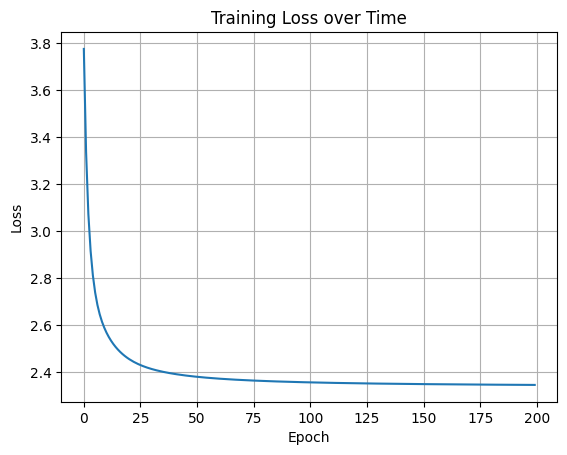

In [12]:
# loss chart
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss over Time')
ax.grid(True)

In [13]:
# sample (empty model without training)
Q = torch.randn((27,27), generator=g, requires_grad=True)

for i in range(5):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # one hot encoding
    logits = xenc @ Q # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

fztmidpwfwxfshxirzan.
fpsxqghvlzrrrbxvkvbkhtaezqzqepdvdpwdkgwdnu.
bcdnosizgdowdcdfkcnjoquthxqzqgvvd.
corrrryvdfsumvyxsjlqxypsfjfrrytupeweexquocvvygltbnjxenjdewxyg.
ipudijexewdov.


In [34]:
# sample (trained model)

for i in range(5):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # one hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

hele.
teruira.
jualdanilar.
reves.
honci.
